In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

First of all, we need the dataset. We can download and it using the following commands.

In [2]:
#!curl -O http://alice.adase.org/media/downloads/dataset_Kids_v0.2_TLiCoxo.zip
#!unzip dataset_Kids.zip

# !curl -O http://alice.adase.org/media/downloads/dataset_mu_rhythm_1.1.zip
# !unzip dataset_mu_rhythm_1.1.zip

In [3]:
from alice_ml.preprocessing import load_dataset

path = '/Users/beliaevaaleksandra/Downloads/dataset_mu_rhythm_1.1'

data, raw_annotations = load_dataset(path, preload=False)

path2 = '/Users/beliaevaaleksandra/Downloads/dataset_mu_rhythm_2_1.2'

data2, raw_annotations2 = load_dataset(path2, preload=False)


In [4]:
def get_target_distribution(annotations):
    # Exclude non-numeric columns like 'user_hash' and other potential object-type columns
    flag_columns = annotations.select_dtypes(include=[bool, int, float]).columns
    # Perform groupby on 'ic_id' and calculate the mean for the flag columns
    return annotations.groupby('ic_id')[flag_columns].mean().apply(lambda x: x.value_counts())
get_target_distribution(raw_annotations)
get_target_distribution(raw_annotations2)

,comment,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_eyes_blinks,flag_muscles_and_movement,flag_muscles,flag_movement,flag_heart,flag_noise,flag_line_noise,flag_ch_noise,flag_uncertain,flag_other
0.0,NaN,NaN,24,12,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
1.0,NaN,36.0,12,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
def propogate_labels(annotations):
    return annotations.assign(flag_brain=annotations[['flag_brain', 'flag_alpha', 'flag_mu']].any(axis=1)) \
                      .drop(columns=['flag_line_noise'])

annotations = propogate_labels(raw_annotations)
get_target_distribution(annotations)

,comment,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_eyes_blinks,flag_muscles_and_movement,flag_muscles,flag_movement,flag_heart,flag_noise,flag_ch_noise,flag_uncertain,flag_other
0.000000,NaN,97.0,130.0,120.0,85.0,132,140.0,124,138.0,146.0,148.0,149.0,146.0,147.0,127.0,149.0
0.500000,NaN,3.0,2.0,NaN,7.0,9,7.0,19,2.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN
0.666667,NaN,NaN,NaN,NaN,NaN,1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.000000,NaN,49.0,17.0,29.0,57.0,7,2.0,5,9.0,1.0,1.0,NaN,3.0,2.0,20.0,NaN


In [6]:
annotations2 = propogate_labels(raw_annotations2)
get_target_distribution(annotations2)

,comment,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_eyes_v,flag_eyes_blinks,flag_muscles_and_movement,flag_muscles,flag_movement,flag_heart,flag_noise,flag_ch_noise,flag_uncertain,flag_other
0.0,NaN,NaN,24,12,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
1.0,NaN,36.0,12,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
from alice_ml.preprocessing import build_target_df
targets = build_target_df(annotations, weights='uniform', strategy='mean', threshold=0.33)

targets[['flag_alpha', 'flag_mu', 'flag_heart']] = build_target_df(annotations, ['flag_alpha', 'flag_mu', 'flag_heart'], strategy='majority')

print(targets.sum())
targets = targets.loc[:, (targets.mean(axis=0) > 0.05) & (targets.all(axis=0) < 0.95)]
targets.head()

flag_brain                   49
flag_alpha                   19
flag_mu                      29
flag_eyes                    64
flag_eyes_h                  11
flag_eyes_v                   3
flag_eyes_blinks              6
flag_muscles_and_movement     8
flag_muscles                  1
flag_movement                 1
flag_heart                    0
flag_noise                    3
flag_ch_noise                 2
flag_uncertain               21
flag_other                    0
dtype: int64


,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_muscles_and_movement,flag_uncertain
ic_id,,,,,,,
IC001181,False,False,False,True,False,False,False
IC001182,True,False,False,False,False,False,False
IC001183,False,False,False,False,False,False,True
IC001184,False,False,False,False,False,False,True
IC001185,True,False,False,False,False,False,True


In [8]:
targets2 = build_target_df(annotations2, weights='uniform', strategy='mean', threshold=0.33)

targets2[['flag_alpha', 'flag_mu', 'flag_heart']] = build_target_df(annotations2, ['flag_alpha', 'flag_mu', 'flag_heart'], strategy='majority')

print(targets2.sum())
targets2 = targets2.loc[:, (targets2.mean(axis=0) > 0.05) & (targets2.all(axis=0) < 0.95)]
targets2.head()

flag_brain                   36
flag_alpha                   12
flag_mu                      24
flag_eyes                     0
flag_eyes_h                   0
flag_eyes_v                   0
flag_eyes_blinks              0
flag_muscles_and_movement     0
flag_muscles                  0
flag_movement                 0
flag_heart                    0
flag_noise                    0
flag_ch_noise                 0
flag_uncertain                0
flag_other                    0
dtype: int64


,flag_alpha,flag_mu
ic_id,,
IC001985,True,False
IC001990,False,True
IC001999,False,True
IC002021,True,False
IC002024,False,True


In [9]:
targets1 = {
    'ic_id': [],
    'flag_alpha' : [],
    'flag_mu': [],
    'flag_brain':[],
    'flag_eyes':[],
    'flag_eyes_h':[],
    'flag_uncertain':[]
}

In [10]:
for k in data.keys():
    if k in targets.index:
        continue
    else:
        targets1['ic_id'].append(k)
        targets1['flag_alpha'].append(False)
        targets1['flag_mu'].append(False)
        targets1['flag_brain'].append(False)
        targets1['flag_eyes'].append(False)
        targets1['flag_eyes_h'].append(False)
        targets1['flag_uncertain'].append(False)

In [11]:
targets1_2 = {
    'ic_id': [],
    'flag_alpha' : [],
    'flag_mu': [],
    'flag_brain':[],
    'flag_eyes':[],
    'flag_eyes_h':[],
    'flag_uncertain':[]
}

In [12]:
for k in data2.keys():
    if k in targets2.index:
        continue
    else:
        targets1_2['ic_id'].append(k)
        targets1_2['flag_alpha'].append(False)
        targets1_2['flag_mu'].append(False)
        targets1_2['flag_brain'].append(False)
        targets1_2['flag_eyes'].append(False)
        targets1_2['flag_eyes_h'].append(False)
        targets1_2['flag_uncertain'].append(False)

In [13]:
targets = pd.concat([targets, pd.DataFrame(targets1).set_index('ic_id')])

In [14]:
targets2 = pd.concat([targets2, pd.DataFrame(targets1_2).set_index('ic_id')])

In [15]:
targets = targets.fillna(False)


/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/4277948533.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  targets = targets.fillna(False)


In [16]:
targets2 = targets2.fillna(False)


/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/2495586107.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  targets2 = targets2.fillna(False)


In [17]:
targets.shape, len(data.keys())

((527, 7), 527)

In [18]:
targets2.shape, len(data2.keys())

((336, 6), 336)

# Testing of new features in ML models

In [19]:
from alice_ml.features import build_feature_df

features = build_feature_df(data)
features

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use fl

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,...,average_persistence_with_phase,spatial_persistence,A_peaks,A_plateaus,A_peaks_freq,A_plateaus_freq,pca1,pca2,avg_persistence,max_persistence
IC001181,2.394026,14.074256,0.350957,0.020189,0.030888,0.226681,0.027488,0.031416,0.147364,-0.122794,...,1.429672,0.144175,0.074022,0.175978,9.265428,8.293834,0.099706,-0.285821,0.027365,0.228620
IC001182,-0.202781,78.412312,0.060472,0.002325,0.053063,0.218715,0.004291,0.004950,0.183362,-0.025954,...,1.340806,0.121335,0.107542,0.347765,8.435934,7.632316,0.046863,-0.244263,0.023887,0.144346
IC001183,0.217014,137.248558,0.052225,-0.002635,0.065720,0.311969,0.003769,0.005342,0.074177,-0.027691,...,1.292065,0.068231,0.093575,0.117318,9.645950,9.558845,0.156498,-0.229528,0.013144,0.036473
IC001184,1.983181,74.136798,-0.192816,-0.020441,0.088582,0.246820,0.001432,0.001503,-0.127449,0.156610,...,1.230299,0.076154,0.067039,0.076816,10.576282,10.707148,-0.236639,0.306388,0.034190,0.140988
IC001185,0.035117,180.334305,-0.142686,-0.013640,0.000192,0.308996,0.004359,0.004855,0.020297,0.144126,...,1.295255,0.089498,0.479050,0.671788,9.926716,9.512111,0.090920,-0.394789,0.018630,0.079815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IC001703,-0.084515,2.230707,0.019098,-0.071933,0.040540,0.138968,0.000114,0.000000,0.093972,-0.065988,...,1.001624,0.049024,0.276018,0.321267,10.462241,10.323954,-0.022159,0.110345,0.028845,0.304367
IC001704,-0.257739,2.887641,-0.086538,-0.036633,0.051408,0.085438,0.000133,0.000000,0.024734,0.165392,...,0.963620,0.138944,0.235294,0.330317,10.187674,9.910158,-0.160349,-0.123247,0.025383,0.102762
IC001705,-0.326352,5.647878,0.114341,-0.002898,0.099278,0.240965,0.000090,0.000030,0.078411,-0.033466,...,0.860711,0.114250,0.031674,0.045249,10.486019,10.682726,-0.152410,-0.062066,0.031931,0.213942
IC001706,-0.392827,1.563865,0.138463,0.184928,0.027151,0.543770,0.000000,0.000000,-0.024452,0.041361,...,0.810406,0.187820,0.013575,0.013575,8.433200,8.433200,0.045762,-0.186324,0.019117,0.149624


In [20]:
from alice_ml.features import build_feature_df

features2 = build_feature_df(data2)
features2

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use fl

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,...,average_persistence_with_phase,spatial_persistence,A_peaks,A_plateaus,A_peaks_freq,A_plateaus_freq,pca1,pca2,avg_persistence,max_persistence
IC001992,-0.053531,238.124964,-0.066652,-0.001406,0.064240,0.285278,0.004681,0.007097,0.130871,-0.014498,...,1.312999,0.140717,0.264095,0.456973,8.990343,8.684973,-0.151558,-0.203370,0.021537,0.070734
IC002008,0.268061,42.472689,0.159405,0.020369,0.499898,0.234599,0.003226,0.004223,0.059369,-0.009872,...,0.726064,0.441243,0.124629,0.175074,9.660227,9.530105,0.115563,-0.367578,0.050988,0.312318
IC002024,0.089427,74.800064,0.009598,-0.006960,0.188323,0.243523,0.004830,0.006146,0.134225,0.009805,...,0.981428,0.247749,0.648464,0.843003,8.312085,8.295222,-0.336528,-0.383863,0.030713,0.223879
IC002040,0.387238,47.153835,-0.041105,0.006523,0.128457,0.169073,0.008472,0.011017,0.019033,0.032819,...,0.930299,0.239807,0.375427,0.597270,8.270762,8.121733,0.274955,-0.561801,0.024294,0.139323
IC002056,-0.622979,19.547078,0.121785,0.006187,0.478816,0.197616,0.002124,0.001838,-0.005284,0.018717,...,0.696058,0.356611,0.073276,0.015086,10.804763,10.844622,-0.033331,-0.254679,0.064753,0.938592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IC002247,-0.346051,1.958688,-0.138244,-0.035329,0.057946,0.067928,0.001614,0.001880,-0.086473,0.151316,...,1.277897,0.181658,0.541841,0.820084,9.775486,9.484000,-0.381393,0.126716,0.038603,0.327550
IC002263,-0.205886,3.138964,0.049312,0.013636,0.335032,0.381675,0.000466,0.000479,0.030966,0.110267,...,0.844700,0.384775,0.048117,0.058577,9.283666,9.016977,0.047274,-0.246131,0.043289,0.209863
IC002279,-0.411610,2.644481,-0.040728,0.001176,0.089518,0.523113,0.000143,0.000312,0.085879,0.092183,...,1.163437,0.061526,0.022727,0.026860,10.508146,10.480193,-0.147122,-0.291740,0.055151,0.771891
IC002295,2.202804,23.556981,-0.039008,0.001592,0.084574,0.134651,0.012137,0.014126,0.012094,0.022385,...,1.290464,0.027893,0.314763,0.440111,9.401140,9.454178,0.082093,-0.421929,0.009435,0.105446


In [21]:
features

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,...,average_persistence_with_phase,spatial_persistence,A_peaks,A_plateaus,A_peaks_freq,A_plateaus_freq,pca1,pca2,avg_persistence,max_persistence
IC001181,2.394026,14.074256,0.350957,0.020189,0.030888,0.226681,0.027488,0.031416,0.147364,-0.122794,...,1.429672,0.144175,0.074022,0.175978,9.265428,8.293834,0.099706,-0.285821,0.027365,0.228620
IC001182,-0.202781,78.412312,0.060472,0.002325,0.053063,0.218715,0.004291,0.004950,0.183362,-0.025954,...,1.340806,0.121335,0.107542,0.347765,8.435934,7.632316,0.046863,-0.244263,0.023887,0.144346
IC001183,0.217014,137.248558,0.052225,-0.002635,0.065720,0.311969,0.003769,0.005342,0.074177,-0.027691,...,1.292065,0.068231,0.093575,0.117318,9.645950,9.558845,0.156498,-0.229528,0.013144,0.036473
IC001184,1.983181,74.136798,-0.192816,-0.020441,0.088582,0.246820,0.001432,0.001503,-0.127449,0.156610,...,1.230299,0.076154,0.067039,0.076816,10.576282,10.707148,-0.236639,0.306388,0.034190,0.140988
IC001185,0.035117,180.334305,-0.142686,-0.013640,0.000192,0.308996,0.004359,0.004855,0.020297,0.144126,...,1.295255,0.089498,0.479050,0.671788,9.926716,9.512111,0.090920,-0.394789,0.018630,0.079815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IC001703,-0.084515,2.230707,0.019098,-0.071933,0.040540,0.138968,0.000114,0.000000,0.093972,-0.065988,...,1.001624,0.049024,0.276018,0.321267,10.462241,10.323954,-0.022159,0.110345,0.028845,0.304367
IC001704,-0.257739,2.887641,-0.086538,-0.036633,0.051408,0.085438,0.000133,0.000000,0.024734,0.165392,...,0.963620,0.138944,0.235294,0.330317,10.187674,9.910158,-0.160349,-0.123247,0.025383,0.102762
IC001705,-0.326352,5.647878,0.114341,-0.002898,0.099278,0.240965,0.000090,0.000030,0.078411,-0.033466,...,0.860711,0.114250,0.031674,0.045249,10.486019,10.682726,-0.152410,-0.062066,0.031931,0.213942
IC001706,-0.392827,1.563865,0.138463,0.184928,0.027151,0.543770,0.000000,0.000000,-0.024452,0.041361,...,0.810406,0.187820,0.013575,0.013575,8.433200,8.433200,0.045762,-0.186324,0.019117,0.149624


In [22]:
features2

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,...,average_persistence_with_phase,spatial_persistence,A_peaks,A_plateaus,A_peaks_freq,A_plateaus_freq,pca1,pca2,avg_persistence,max_persistence
IC001992,-0.053531,238.124964,-0.066652,-0.001406,0.064240,0.285278,0.004681,0.007097,0.130871,-0.014498,...,1.312999,0.140717,0.264095,0.456973,8.990343,8.684973,-0.151558,-0.203370,0.021537,0.070734
IC002008,0.268061,42.472689,0.159405,0.020369,0.499898,0.234599,0.003226,0.004223,0.059369,-0.009872,...,0.726064,0.441243,0.124629,0.175074,9.660227,9.530105,0.115563,-0.367578,0.050988,0.312318
IC002024,0.089427,74.800064,0.009598,-0.006960,0.188323,0.243523,0.004830,0.006146,0.134225,0.009805,...,0.981428,0.247749,0.648464,0.843003,8.312085,8.295222,-0.336528,-0.383863,0.030713,0.223879
IC002040,0.387238,47.153835,-0.041105,0.006523,0.128457,0.169073,0.008472,0.011017,0.019033,0.032819,...,0.930299,0.239807,0.375427,0.597270,8.270762,8.121733,0.274955,-0.561801,0.024294,0.139323
IC002056,-0.622979,19.547078,0.121785,0.006187,0.478816,0.197616,0.002124,0.001838,-0.005284,0.018717,...,0.696058,0.356611,0.073276,0.015086,10.804763,10.844622,-0.033331,-0.254679,0.064753,0.938592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IC002247,-0.346051,1.958688,-0.138244,-0.035329,0.057946,0.067928,0.001614,0.001880,-0.086473,0.151316,...,1.277897,0.181658,0.541841,0.820084,9.775486,9.484000,-0.381393,0.126716,0.038603,0.327550
IC002263,-0.205886,3.138964,0.049312,0.013636,0.335032,0.381675,0.000466,0.000479,0.030966,0.110267,...,0.844700,0.384775,0.048117,0.058577,9.283666,9.016977,0.047274,-0.246131,0.043289,0.209863
IC002279,-0.411610,2.644481,-0.040728,0.001176,0.089518,0.523113,0.000143,0.000312,0.085879,0.092183,...,1.163437,0.061526,0.022727,0.026860,10.508146,10.480193,-0.147122,-0.291740,0.055151,0.771891
IC002295,2.202804,23.556981,-0.039008,0.001592,0.084574,0.134651,0.012137,0.014126,0.012094,0.022385,...,1.290464,0.027893,0.314763,0.440111,9.401140,9.454178,0.082093,-0.421929,0.009435,0.105446


In [23]:
features.columns

Index(['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT',
       'MT', 'AMALB', 'SMR_Power', 'average_persistence_with_phase',
       'spatial_persistence', 'A_peaks', 'A_plateaus', 'A_peaks_freq',
       'A_plateaus_freq', 'pca1', 'pca2', 'avg_persistence',
       'max_persistence'],
      dtype='object')

In [24]:
features = features.loc[targets.index]


In [25]:
features2 = features2.loc[targets2.index]


In [26]:
# Определяем необходимые колонки для feature_old и feature_iteration_1
columns_feature_old = ['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT', 'MT', 'AMALB']
columns_feature_iteration_1 = ['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT', 'MT', 'AMALB', 
                               'A_peaks', 'A_plateaus', 'A_peaks_freq', 'A_plateaus_freq', 'pca1', 'pca2']

# Создаем новые DataFrame с нужными колонками
feature_old = features[columns_feature_old]
feature_iteration_1 = features[columns_feature_iteration_1]

In [27]:
# Определяем необходимые колонки для feature_old и feature_iteration_1
columns_feature_old = ['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT', 'MT', 'AMALB']
columns_feature_iteration_1 = ['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT', 'MT', 'AMALB', 
                               'A_peaks', 'A_plateaus', 'A_peaks_freq', 'A_plateaus_freq', 'pca1', 'pca2']

# Создаем новые DataFrame с нужными колонками
feature_2_old = features2[columns_feature_old]
feature_2_iteration_1 = features2[columns_feature_iteration_1]

In [28]:
targets

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_eyes_h,flag_muscles_and_movement,flag_uncertain
ic_id,,,,,,,
IC001181,False,False,False,True,False,False,False
IC001182,True,False,False,False,False,False,False
IC001183,False,False,False,False,False,False,True
IC001184,False,False,False,False,False,False,True
IC001185,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...
IC001703,False,False,False,False,False,False,False
IC001704,False,False,False,False,False,False,False
IC001705,False,False,False,False,False,False,False


In [29]:
targets2

,flag_alpha,flag_mu,flag_brain,flag_eyes,flag_eyes_h,flag_uncertain
ic_id,,,,,,
IC001985,True,False,False,False,False,False
IC001990,False,True,False,False,False,False
IC001999,False,True,False,False,False,False
IC002021,True,False,False,False,False,False
IC002024,False,True,False,False,False,False
...,...,...,...,...,...,...
IC002247,False,False,False,False,False,False
IC002263,False,False,False,False,False,False
IC002279,False,False,False,False,False,False


In [30]:
columns_to_drop = ['flag_muscles_and_movement', 'flag_brain', 'flag_eyes', 'flag_eyes_h', 'flag_uncertain', 'flag_heart', 'flag_ch_noise', 'flag_muscles']
targets = targets.drop(columns=[col for col in columns_to_drop if col in targets.columns], errors='ignore')

In [31]:
targets2 = targets2.drop(columns=[col for col in columns_to_drop if col in targets2.columns], errors='ignore')

In [32]:
targets

,flag_alpha,flag_mu
ic_id,,
IC001181,False,False
IC001182,False,False
IC001183,False,False
IC001184,False,False
IC001185,False,False
...,...,...
IC001703,False,False
IC001704,False,False
IC001705,False,False


In [33]:
targets2

,flag_alpha,flag_mu
ic_id,,
IC001985,True,False
IC001990,False,True
IC001999,False,True
IC002021,True,False
IC002024,False,True
...,...,...
IC002247,False,False
IC002263,False,False
IC002279,False,False


In [34]:
targets_mu_combined = pd.concat([targets, targets2])
targets_mu_combined = targets_mu_combined.dropna(axis=1)

In [35]:
features_mu_combined = pd.concat([features, features2])
features_mu_old_combined = features_mu_combined[columns_feature_old]
features_mu_iteration_1_combined  = features_mu_combined[columns_feature_iteration_1]


In [36]:
features_mu_combined.to_csv('features_Mu_Rhythm_all.csv')


For training we use XGboost, LinearSVM, and Logistic Regression with default parameters. We do a stratified train-test split with test size = 0.3.

In [37]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler

models = {
    'LR': LogisticRegression(solver='liblinear', penalty='l1', C=1.0),
    'XGB': XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=30, eval_metric='logloss', use_label_encoder=False),
    'SVM': SVC(C=0.1, kernel='linear', probability=True),
    'CatBoost': CatBoostClassifier(depth=4, iterations=200, learning_rate=0.1, verbose=0),
    'AdaBoost': AdaBoostClassifier(learning_rate=0.5, n_estimators=50)
}
n_repeats = 50

In [38]:
from sklearn.model_selection import train_test_split

def repeated_train_test(features, target, model, n_repeats, test_size=0.3, axes=None, random_state=57):
    y_true = []
    y_pred = []
    y_proba = []
    np.random.seed(random_state)

    for _ in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, stratify=target)
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        model.fit(X_train, y_train)
        y_true.append(y_test)
        y_pred.append(model.predict(X_test))
        y_proba.append(model.predict_proba(X_test)[:, 1])

    return np.array(y_true), np.array(y_pred), np.array(y_proba)


In [39]:
from alice_ml.vis import plot_aggregated_pr_curve, plot_aggregated_roc_curve
from itertools import product
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lime.lime_tabular import LimeTabularExplainer
import shap

# Функция для получения метрик AUC для ROC и PR кривых
def get_aucs(true, proba):
    roc_aucs, pr_aucs = [], []
    for y_t, y_p in zip(true, proba):
        fpr, tpr, _ = roc_curve(y_t, y_p, drop_intermediate=False)
        prec, rec, _ = precision_recall_curve(y_t, y_p)
        roc_aucs.append(auc(fpr, tpr))
        pr_aucs.append(auc(rec, prec))
    return roc_aucs, pr_aucs

# Функция для построения графиков ROC и PR для каждого набора признаков
def plot_curves_grid(features, targets, models):
    # Создание подграфиков для ROC и PR кривых
    fig_roc, axes_roc = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))
    fig_pr, axes_pr = plt.subplots(len(models), len(targets.columns), figsize=(4 * len(targets.columns), 3 * len(models)))

    # Инициализация DataFrames для хранения метрик
    roc_aucs = {i: pd.DataFrame(index=models, columns=targets.columns, dtype=float) for i in range(3)}
    pr_aucs = {i: pd.DataFrame(index=models, columns=targets.columns, dtype=float) for i in range(3)}
    f1_scores = {i: pd.DataFrame(index=models, columns=targets.columns, dtype=float) for i in range(3)}
    macro_f1_scores = {i: pd.DataFrame(index=models, columns=targets.columns, dtype=float) for i in range(3)}
    confusion_matrices = {i: {} for i in range(3)}

    # Основной цикл по моделям и целевым меткам
    for (model_name, model), row_roc, row_pr in zip(models.items(), axes_roc, axes_pr):
        for flag, ax_roc, ax_pr in zip(targets, row_roc, row_pr):
            for i in range(3):
                y_true, y_pred, y_proba = repeated_train_test(features[i], targets[flag], model, n_repeats)
                
                # ROC и PR кривые для каждой фичи
                plot_aggregated_roc_curve(y_true, y_proba, ax_roc, color=['blue', 'orange', 'green'][i])
                plot_aggregated_pr_curve(y_true, y_proba, ax_pr, color=['blue', 'orange', 'green'][i])
                
                # Вычисление метрик и их сохранение
                roc_auc_values, pr_auc_values = get_aucs(y_true, y_proba)
                f1_score_values = [f1_score(y_t, y_p, average='binary') for y_t, y_p in zip(y_true, y_pred)]
                macro_f1_values = [f1_score(y_t, y_p, average='macro') for y_t, y_p in zip(y_true, y_pred)]
                confusion_matrices[i][(model_name, flag)] = confusion_matrix(np.concatenate(y_true), np.concatenate(y_pred))

                # Сохранение средних значений метрик
                roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
                pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
                f1_scores[i].loc[model_name, flag] = f"{np.mean(f1_score_values):.4f} ± {np.std(f1_score_values):.4f}"
                macro_f1_scores[i].loc[model_name, flag] = f"{np.mean(macro_f1_values):.4f} ± {np.std(macro_f1_values):.4f}"

                # Печать отчета классификации
                print(f"Classification Report for {model_name} - {flag}:")
                print(classification_report(np.concatenate(y_true), np.concatenate(y_pred)))

        row_roc[0].set_ylabel(model_name, fontsize=28, labelpad=16)
        row_pr[0].set_ylabel(model_name, fontsize=28, labelpad=16)

        row_roc[-1].set_ylabel('True positive rate', fontsize=18)
        row_pr[-1].set_ylabel('Precision', fontsize=18)
        row_roc[-1].yaxis.set_label_position('right')
        row_pr[-1].yaxis.set_label_position('right')

    for target_name, ax_roc, ax_pr in zip(targets, axes_roc[0], axes_pr[0]):
        ax_roc.set_title(target_name[5:].capitalize(), fontsize=28, pad=16)
        ax_pr.set_title(target_name[5:].capitalize(), fontsize=28, pad=16)

    for ax_roc, ax_pr in zip(axes_roc[-1], axes_pr[-1]):
        ax_roc.set_xlabel('False positive rate', fontsize=18)
        ax_pr.set_xlabel('Recall', fontsize=18)

    fig_roc.subplots_adjust(wspace=0.1, hspace=0.1)
    fig_pr.subplots_adjust(wspace=0.1, hspace=0.1)

    for row_roc, row_pr in zip(axes_roc[:-1], axes_pr[:-1]):
        for ax_roc, ax_pr in zip(row_roc, row_pr):
            plt.setp(ax_roc.get_xticklabels(), visible=False)
            plt.setp(ax_pr.get_xticklabels(), visible=False)

    for row_roc, row_pr in zip(axes_roc, axes_pr):
        for ax_roc, ax_pr in zip(row_roc[:-1], row_pr[:-1]):
            plt.setp(ax_roc.get_yticklabels(), visible=False)
            plt.setp(ax_pr.get_yticklabels(), visible=False)

    return fig_roc, fig_pr, roc_aucs, pr_aucs, f1_scores, macro_f1_scores, confusion_matrices

# Функция для вывода всех метрик
def display_metrics(roc_aucs, pr_aucs, f1_scores, macro_f1_scores, confusion_matrices):
    # Выводим ROC AUC для всех фич
    for i in roc_aucs:
        print(f"ROC AUC for feature set {i}:")
        print(roc_aucs[i])
        print("\n")
        
    # Выводим PR AUC для всех фич
    for i in pr_aucs:
        print(f"PR AUC for feature set {i}:")
        print(pr_aucs[i])
        print("\n")
        
    # Выводим F1 score для всех фич
    for i in f1_scores:
        print(f"F1 Score for feature set {i}:")
        print(f1_scores[i])
        print("\n")
        
    # Выводим Macro F1 score для всех фич
    for i in macro_f1_scores:
        print(f"Macro F1 Score for feature set {i}:")
        print(macro_f1_scores[i])
        print("\n")
    
    # Выводим Confusion Matrices для всех моделей и фич
    for i in confusion_matrices:
        print(f"Confusion Matrices for feature set {i}:")
        for (model_name, flag), matrix in confusion_matrices[i].items():
            print(f"Confusion Matrix for {model_name} - {flag}:")
            print(matrix)
            print("\n")

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9188 ± 0.0348' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3998 ± 0.1150' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98     12500
        True       0.25      0.01      0.02       450

    accuracy                           0.96     12950
   macro avg       0.61      0.50      0.50     12950
weighted avg       0.94      0.96      0.95     12950



/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9319 ± 0.0436' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4840 ± 0.1210' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98     12500
        True       0.64      0.17      0.26       450

    accuracy                           0.97     12950
   macro avg       0.80      0.58      0.62     12950
weighted avg       0.96      0.97      0.96     12950



/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9297 ± 0.0436' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4667 ± 0.1239' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98     12500
        True       0.54      0.16      0.24       450

    accuracy                           0.97     12950
   macro avg       0.75      0.58      0.61     12950
weighted avg       0.96      0.97      0.96     12950



/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7715 ± 0.0425' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1726 ± 0.0359' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_mu:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     12150
        True       0.06      0.00      0.01       800

    accuracy                           0.93     12950
   macro avg       0.50      0.50      0.49     12950
weighted avg       0.88      0.93      0.91     12950



/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9053 ± 0.0278' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3714 ± 0.0876' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.98      0.96     12150
        True       0.39      0.17      0.24       800

    accuracy                           0.93     12950
   macro avg       0.67      0.58      0.60     12950
weighted avg       0.91      0.93      0.92     12950



/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9296 ± 0.0213' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4565 ± 0.0985' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_mu:
              precision    recall  f1-score   support

       False       0.96      0.98      0.97     12150
        True       0.54      0.31      0.39       800

    accuracy                           0.94     12950
   macro avg       0.75      0.65      0.68     12950
weighted avg       0.93      0.94      0.93     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12500
        True       0.50      0.26      0.34       450

    accuracy                           0.97     12950
   macro avg       0.74      0.63      0.66     12950
weighted avg       0.96      0.97      0.96     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12500
        True       0.53      0.28      0.37       450

    accuracy                           0.97     12950
   macro avg       0.75      0.64      0.68     12950
weighted avg       0.96      0.97      0.96     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12500
        True       0.52      0.28      0.36       450

    accuracy                           0.97     12950
   macro avg       0.75      0.63      0.67     12950
weighted avg       0.96      0.97      0.96     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     12150
        True       0.56      0.21      0.31       800

    accuracy                           0.94     12950
   macro avg       0.76      0.60      0.64     12950
weighted avg       0.93      0.94      0.93     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12150
        True       0.80      0.54      0.65       800

    accuracy                           0.96     12950
   macro avg       0.89      0.77      0.81     12950
weighted avg       0.96      0.96      0.96     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12150
        True       0.81      0.60      0.69       800

    accuracy                           0.97     12950
   macro avg       0.89      0.79      0.83     12950
weighted avg       0.96      0.97      0.96     12950

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98     12500
        True       0.00      0.00      0.00       450

    accuracy                           0.97     12950
   macro avg       0.48      0.50      0.49     12950
weighted avg       0.93      0.97      0.95     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98     12500
        True       0.00      0.00      0.00       450

    accuracy                           0.97     12950
   macro avg       0.48      0.50      0.49     12950
weighted avg       0.93      0.97      0.95     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98     12500
        True       0.00      0.00      0.00       450

    accuracy                           0.97     12950
   macro avg       0.48      0.50      0.49     12950
weighted avg       0.93      0.97      0.95     12950

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     12150
        True       0.00      0.00      0.00       800

    accuracy                           0.94     12950
   macro avg       0.47      0.50      0.48     12950
weighted avg       0.88      0.94      0.91     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     12150
        True       0.00      0.00      0.00       800

    accuracy                           0.94     12950
   macro avg       0.47      0.50      0.48     12950
weighted avg       0.88      0.94      0.91     12950

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     12150
        True       0.44      0.04      0.06       800

    accuracy                           0.94     12950
   macro avg       0.69      0.52      0.52     12950
weighted avg       0.91      0.94      0.91     12950

Classification Report for CatBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12500
        True       0.48      0.26      0.34       450

    accuracy                           0.96     129

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12500
        True       0.39      0.23      0.29       450

    accuracy                           0.96     12950
   macro avg       0.68      0.61      0.64     12950
weighted avg       0.95      0.96      0.96     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12500
        True       0.45      0.29      0.35       450

    accuracy                           0.96     12950
   macro avg       0.71      0.64      0.67     12950
weighted avg       0.96      0.96      0.96     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12500
        True       0.38      0.25      0.30       450

    accuracy                           0.96     12950
   macro avg       0.68      0.62      0.64     12950
weighted avg       0.95      0.96      0.96     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.98      0.96     12150
        True       0.39      0.19      0.25       800

    accuracy                           0.93     12950
   macro avg       0.67      0.58      0.61     12950
weighted avg       0.91      0.93      0.92     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12150
        True       0.73      0.48      0.58       800

    accuracy                           0.96     12950
   macro avg       0.85      0.74      0.78     12950
weighted avg       0.95      0.96      0.95     12950



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.97      0.99      0.98     12150
        True       0.73      0.56      0.63       800

    accuracy                           0.96     12950
   macro avg       0.85      0.77      0.81     12950
weighted avg       0.96      0.96      0.96     12950



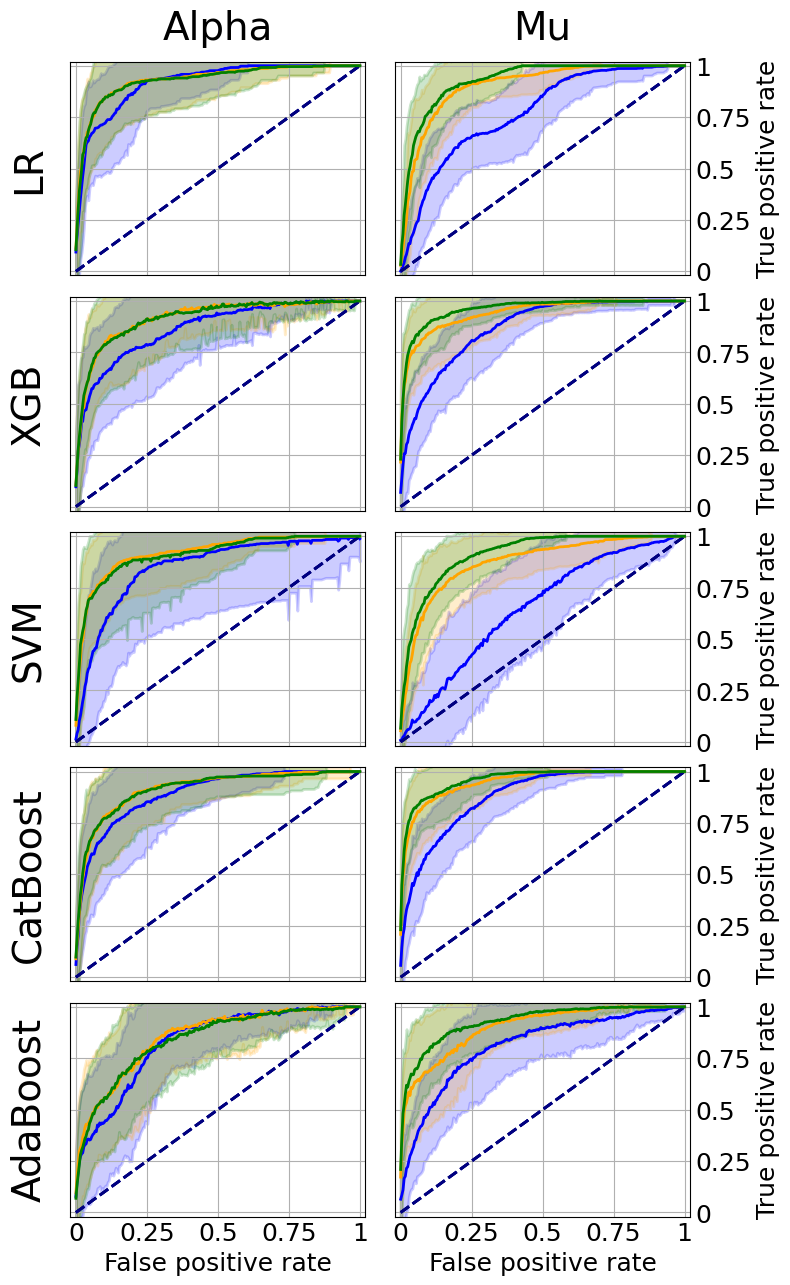

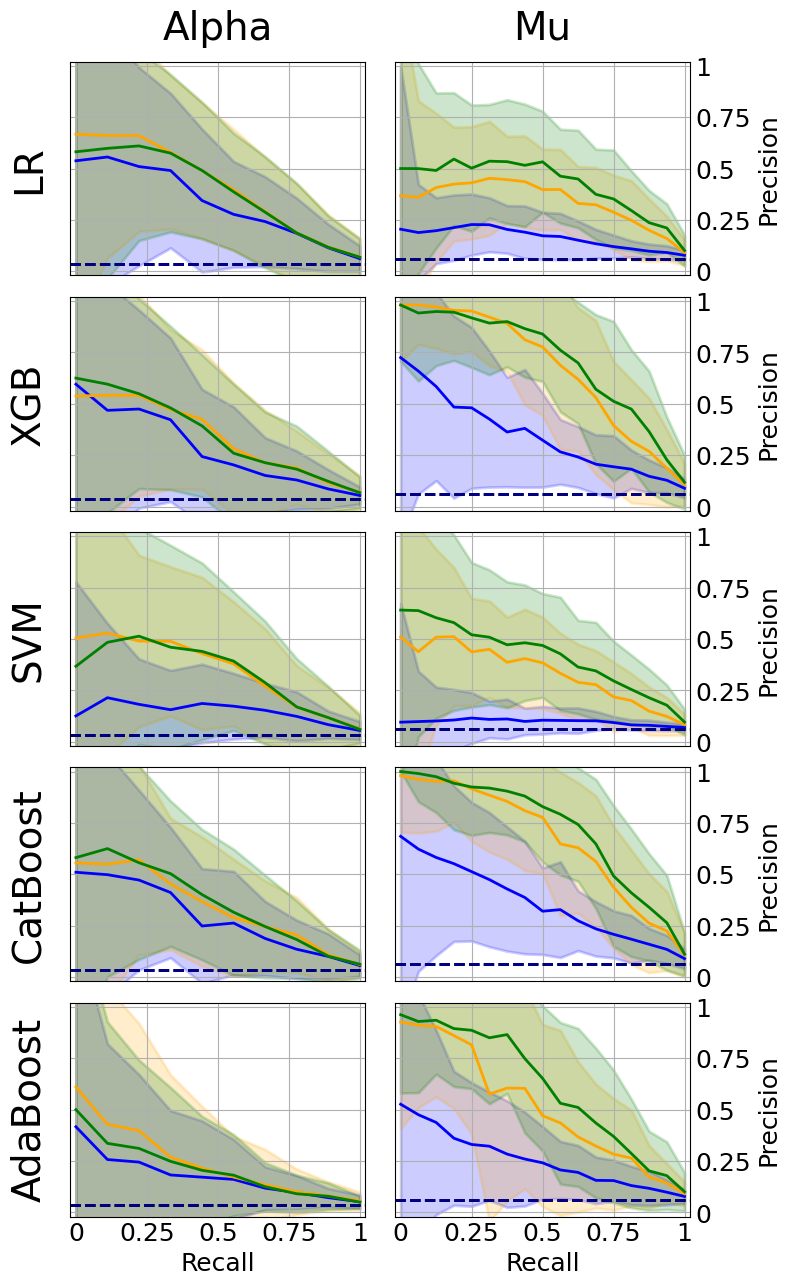

In [40]:
fig_roc, fig_pr, roc_aucs, pr_aucs, f1_scores, macro_f1_scores, confusion_matrices = plot_curves_grid([features_mu_old_combined, features_mu_iteration_1_combined, features_mu_combined], targets_mu_combined, models)

In [41]:
# Вывод всех метрик
display_metrics(roc_aucs, pr_aucs, f1_scores, macro_f1_scores, confusion_matrices)

ROC AUC for feature set 0:
               flag_alpha          flag_mu
LR        0.9188 ± 0.0348  0.7715 ± 0.0425
XGB       0.8675 ± 0.0583  0.8675 ± 0.0325
SVM       0.8504 ± 0.1178  0.6529 ± 0.0665
CatBoost  0.8946 ± 0.0403  0.8799 ± 0.0283
AdaBoost  0.8286 ± 0.0471  0.8112 ± 0.0512


ROC AUC for feature set 1:
               flag_alpha          flag_mu
LR        0.9319 ± 0.0436  0.9053 ± 0.0278
XGB       0.9180 ± 0.0487  0.9436 ± 0.0287
SVM       0.9215 ± 0.0430  0.8755 ± 0.0364
CatBoost  0.9172 ± 0.0367  0.9507 ± 0.0238
AdaBoost  0.8532 ± 0.0599  0.9015 ± 0.0389


ROC AUC for feature set 2:
               flag_alpha          flag_mu
LR        0.9297 ± 0.0436  0.9296 ± 0.0213
XGB       0.9165 ± 0.0572  0.9626 ± 0.0184
SVM       0.9147 ± 0.0579  0.9160 ± 0.0255
CatBoost  0.9157 ± 0.0430  0.9625 ± 0.0173
AdaBoost  0.8433 ± 0.0544  0.9301 ± 0.0339


PR AUC for feature set 0:
               flag_alpha          flag_mu
LR        0.3998 ± 0.1150  0.1726 ± 0.0359
XGB       0.3541 ± 0.1423  

# Testing features on the combined Mu Rhythm+Kids dataset

In [42]:
path_kids = '/Users/beliaevaaleksandra/Downloads/dataset_kids_10.0'

data_kids, raw_annotations_kids = load_dataset(path_kids, preload=False)

In [43]:
annotations_kids = propogate_labels(raw_annotations_kids)
targets_kids = build_target_df(annotations_kids, weights='uniform', strategy='mean', threshold=0.33)

targets_kids[['flag_alpha', 'flag_mu', 'flag_heart']] = build_target_df(annotations_kids, 
                                                                        ['flag_alpha', 'flag_mu', 'flag_heart'], 
                                                                        strategy='majority')

print(targets_kids.sum())
targets_kids = targets_kids.loc[:, (targets_kids.mean(axis=0) > 0.05) & (targets_kids.all(axis=0) < 0.95)]

flag_brain       443
flag_alpha        52
flag_mu           54
flag_eyes         57
flag_eyes_h       11
flag_eyes_v       11
flag_muscles     142
flag_heart       131
flag_ch_noise     68
dtype: int64


In [44]:
targets_kids

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
ic_id,,,,,,,
IC000262,False,False,False,False,False,False,False
IC000263,True,False,False,False,False,False,False
IC000264,True,False,False,False,False,True,False
IC000265,True,False,False,False,False,False,False
IC000266,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...
IC000877,True,False,False,False,False,False,False
IC000878,True,False,False,False,True,False,False
IC000879,True,False,False,False,False,False,False


In [45]:
targets_kids = targets_kids.fillna(False)


In [46]:
targets_kids

,flag_brain,flag_alpha,flag_mu,flag_eyes,flag_muscles,flag_heart,flag_ch_noise
ic_id,,,,,,,
IC000262,False,False,False,False,False,False,False
IC000263,True,False,False,False,False,False,False
IC000264,True,False,False,False,False,True,False
IC000265,True,False,False,False,False,False,False
IC000266,True,False,False,False,False,True,False
...,...,...,...,...,...,...,...
IC000877,True,False,False,False,False,False,False
IC000878,True,False,False,False,True,False,False
IC000879,True,False,False,False,False,False,False


In [47]:
targets_kids.shape, len(data_kids.keys())

((620, 7), 620)

In [48]:
features_kids = build_feature_df(data_kids)

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sfreq = float(sfreq)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/mne/io/meas_info.py:2066: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use fl

In [49]:
features_kids = features_kids.loc[targets_kids.index]

In [50]:
targets_kids = targets_kids.drop(columns=[col for col in columns_to_drop if col in targets_kids.columns], errors='ignore')


In [51]:
targets_kids

,flag_alpha,flag_mu
ic_id,,
IC000262,False,False
IC000263,False,False
IC000264,False,False
IC000265,False,False
IC000266,False,False
...,...,...
IC000877,False,False
IC000878,False,False
IC000879,False,False


In [52]:
targets_combined = pd.concat([targets_mu_combined, targets_kids])

In [53]:
targets_combined = targets_combined.dropna(axis=1)

In [54]:
targets_combined

,flag_alpha,flag_mu
ic_id,,
IC001181,False,False
IC001182,False,False
IC001183,False,False
IC001184,False,False
IC001185,False,False
...,...,...
IC000877,False,False
IC000878,False,False
IC000879,False,False


In [55]:
features_combined = pd.concat([features_mu_combined, features_kids])

In [56]:
# Определяем необходимые колонки для feature_old и feature_iteration_1
columns_feature_old = ['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT', 'MT', 'AMALB']
columns_feature_iteration_1 = ['K', 'MEV', 'SAD', 'SVD', 'SED', 'MIF', 'CORR_BL', 'CORR_MOVE', 'AT', 'MT', 'AMALB', 
                               'A_peaks', 'A_plateaus', 'A_peaks_freq', 'A_plateaus_freq', 'pca1', 'pca2']

# Создаем новые DataFrame с нужными колонками
features_old_combined  = features_combined[columns_feature_old]
features_iteration_1_combined  = features_combined[columns_feature_iteration_1]

In [57]:
features_combined

,K,MEV,SAD,SVD,SED,MIF,CORR_BL,CORR_MOVE,AT,MT,...,average_persistence_with_phase,spatial_persistence,A_peaks,A_plateaus,A_peaks_freq,A_plateaus_freq,pca1,pca2,avg_persistence,max_persistence
ic_id,,,,,,,,,,,,,,,,,,,,,
IC001181,2.394026,14.074256,0.350957,0.020189,0.030888,0.226681,0.027488,0.031416,0.147364,-0.122794,...,1.429672,0.144175,0.074022,0.175978,9.265428,8.293834,0.099706,-0.285821,0.027365,0.228620
IC001182,-0.202781,78.412312,0.060472,0.002325,0.053063,0.218715,0.004291,0.004950,0.183362,-0.025954,...,1.340806,0.121335,0.107542,0.347765,8.435934,7.632316,0.046863,-0.244263,0.023887,0.144346
IC001183,0.217014,137.248558,0.052225,-0.002635,0.065720,0.311969,0.003769,0.005342,0.074177,-0.027691,...,1.292065,0.068231,0.093575,0.117318,9.645950,9.558845,0.156498,-0.229528,0.013144,0.036473
IC001184,1.983181,74.136798,-0.192816,-0.020441,0.088582,0.246820,0.001432,0.001503,-0.127449,0.156610,...,1.230299,0.076154,0.067039,0.076816,10.576282,10.707148,-0.236639,0.306388,0.034190,0.140988
IC001185,0.035117,180.334305,-0.142686,-0.013640,0.000192,0.308996,0.004359,0.004855,0.020297,0.144126,...,1.295255,0.089498,0.479050,0.671788,9.926716,9.512111,0.090920,-0.394789,0.018630,0.079815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IC000877,-0.146957,6.988684,0.042727,-0.004911,0.025780,0.121094,0.000665,0.001510,0.065716,0.016142,...,1.421058,0.049098,0.123077,0.186154,9.691334,9.428744,0.215362,-0.295442,0.017601,0.097895
IC000878,-0.239456,3.270491,-0.024471,-0.000694,0.116370,0.088207,0.001756,0.001765,-0.005558,0.079040,...,1.462171,0.147127,0.166154,0.315385,9.166951,8.873278,0.124337,-0.303670,0.017101,0.082855
IC000879,-0.205477,4.605998,0.052680,0.000121,0.037387,0.114119,0.000769,0.000845,0.049253,-0.022909,...,1.473940,0.057561,0.098462,0.200000,9.669766,9.366365,0.084212,-0.262484,0.011310,0.033922


In [58]:
features_combined.to_csv('features_Mu_Rhythm_Kids.csv')

/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7958 ± 0.0330' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2339 ± 0.0660' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     21000
        True       0.08      0.00      0.01      1250

    accuracy                           0.94     22250
   macro avg       0.51      0.50      0.49     22250
weighted avg       0.90      0.94      0.92     22250



/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8864 ± 0.0227' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3980 ± 0.0812' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     21000
        True       0.60      0.19      0.28      1250

    accuracy                           0.95     22250
   macro avg       0.78      0.59      0.63     22250
weighted avg       0.93      0.95      0.93     22250



/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8950 ± 0.0200' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4113 ± 0.0809' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     21000
        True       0.61      0.22      0.33      1250

    accuracy                           0.95     22250
   macro avg       0.78      0.61      0.65     22250
weighted avg       0.94      0.95      0.94     22250



/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7760 ± 0.0385' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2534 ± 0.0428' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_mu:
              precision    recall  f1-score   support

       False       0.93      1.00      0.96     20650
        True       0.40      0.02      0.04      1600

    accuracy                           0.93     22250
   macro avg       0.67      0.51      0.50     22250
weighted avg       0.89      0.93      0.90     22250



/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8802 ± 0.0259' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4383 ± 0.0651' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_mu:
              precision    recall  f1-score   support

       False       0.94      0.99      0.97     20650
        True       0.64      0.20      0.30      1600

    accuracy                           0.93     22250
   macro avg       0.79      0.60      0.64     22250
weighted avg       0.92      0.93      0.92     22250



/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9074 ± 0.0234' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  roc_aucs[i].loc[model_name, flag] = f"{np.mean(roc_auc_values):.4f} ± {np.std(roc_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:51: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5203 ± 0.0714' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pr_aucs[i].loc[model_name, flag] = f"{np.mean(pr_auc_values):.4f} ± {np.std(pr_auc_values):.4f}"
/var/folders/1v/lp_rmhsx2x5cj9kbz4wt35d00000gn/T/ipykernel_53395/3867208689.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will rais

Classification Report for LR - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     20650
        True       0.64      0.29      0.40      1600

    accuracy                           0.94     22250
   macro avg       0.79      0.64      0.68     22250
weighted avg       0.93      0.94      0.93     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     21000
        True       0.55      0.24      0.33      1250

    accuracy                           0.95     22250
   macro avg       0.75      0.61      0.65     22250
weighted avg       0.93      0.95      0.94     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     21000
        True       0.61      0.31      0.41      1250

    accuracy                           0.95     22250
   macro avg       0.78      0.65      0.69     22250
weighted avg       0.94      0.95      0.94     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     21000
        True       0.62      0.31      0.41      1250

    accuracy                           0.95     22250
   macro avg       0.79      0.65      0.69     22250
weighted avg       0.94      0.95      0.94     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.94      0.99      0.97     20650
        True       0.63      0.23      0.34      1600

    accuracy                           0.94     22250
   macro avg       0.79      0.61      0.65     22250
weighted avg       0.92      0.94      0.92     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     20650
        True       0.72      0.39      0.50      1600

    accuracy                           0.95     22250
   macro avg       0.84      0.69      0.74     22250
weighted avg       0.94      0.95      0.94     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Classification Report for XGB - flag_mu:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     20650
        True       0.72      0.42      0.53      1600

    accuracy                           0.95     22250
   macro avg       0.84      0.70      0.75     22250
weighted avg       0.94      0.95      0.94     22250

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     21000
        True       0.00      0.00      0.00      1250

    accuracy                           0.94     22250
   macro avg       0.47      0.50      0.49     22250
weighted avg       0.89      0.94      0.92     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     21000
        True       0.00      0.00      0.00      1250

    accuracy                           0.94     22250
   macro avg       0.47      0.50      0.49     22250
weighted avg       0.89      0.94      0.92     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_alpha:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97     21000
        True       0.00      0.00      0.00      1250

    accuracy                           0.94     22250
   macro avg       0.47      0.50      0.49     22250
weighted avg       0.89      0.94      0.92     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.93      1.00      0.96     20650
        True       0.00      0.00      0.00      1600

    accuracy                           0.93     22250
   macro avg       0.46      0.50      0.48     22250
weighted avg       0.86      0.93      0.89     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.93      1.00      0.96     20650
        True       0.00      0.00      0.00      1600

    accuracy                           0.93     22250
   macro avg       0.46      0.50      0.48     22250
weighted avg       0.86      0.93      0.89     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

Classification Report for SVM - flag_mu:
              precision    recall  f1-score   support

       False       0.93      1.00      0.96     20650
        True       0.75      0.04      0.08      1600

    accuracy                           0.93     22250
   macro avg       0.84      0.52      0.52     22250
weighted avg       0.92      0.93      0.90     22250

Classification Report for CatBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     21000
        True       0.59      0.27      0.37      1250

    accuracy                           0.95     22250
   macro avg       0.77      0.63      0.67     22250
weighted avg       0.94      0.95      0.94     22250

Classification Report for CatBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     21000
        True       0.59      0.30      0.40      1250

    accuracy                           0.95

/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     21000
        True       0.52      0.18      0.27      1250

    accuracy                           0.94     22250
   macro avg       0.74      0.58      0.62     22250
weighted avg       0.93      0.94      0.93     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     21000
        True       0.58      0.25      0.35      1250

    accuracy                           0.95     22250
   macro avg       0.77      0.62      0.66     22250
weighted avg       0.94      0.95      0.94     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_alpha:
              precision    recall  f1-score   support

       False       0.96      0.99      0.97     21000
        True       0.57      0.26      0.35      1250

    accuracy                           0.95     22250
   macro avg       0.76      0.62      0.66     22250
weighted avg       0.94      0.95      0.94     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.94      0.99      0.96     20650
        True       0.59      0.14      0.22      1600

    accuracy                           0.93     22250
   macro avg       0.76      0.56      0.59     22250
weighted avg       0.91      0.93      0.91     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     20650
        True       0.70      0.37      0.49      1600

    accuracy                           0.94     22250
   macro avg       0.82      0.68      0.73     22250
weighted avg       0.93      0.94      0.94     22250



/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/beliaevaaleksandra/homeworks/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

Classification Report for AdaBoost - flag_mu:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97     20650
        True       0.70      0.40      0.51      1600

    accuracy                           0.94     22250
   macro avg       0.83      0.69      0.74     22250
weighted avg       0.94      0.94      0.94     22250



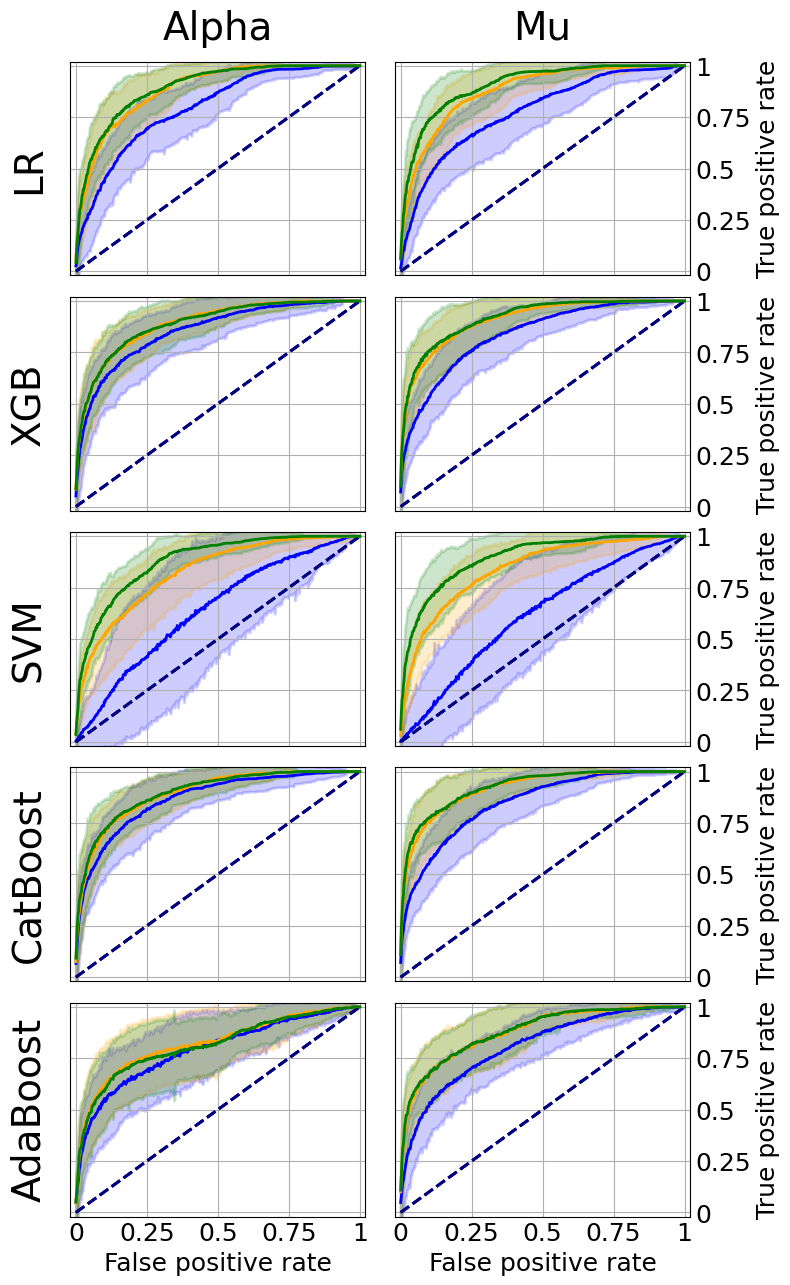

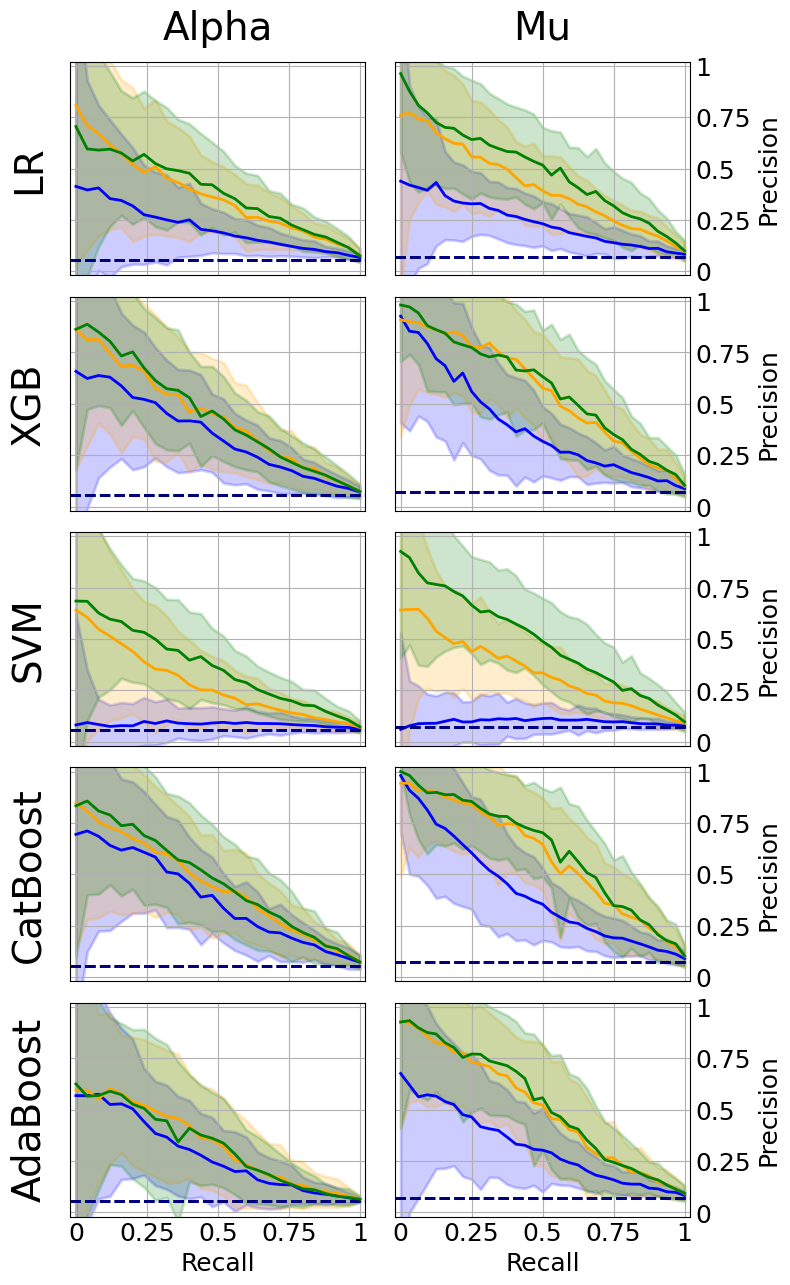

In [59]:
fig_roc_combined, fig_pr_combined, roc_aucs_combined, pr_aucs_combined, f1_scores_combined, macro_f1_scores_combined, confusion_matrices_combined = plot_curves_grid([features_old_combined, features_iteration_1_combined, features_combined], targets_combined, models)

In [60]:
display_metrics(roc_aucs_combined, pr_aucs_combined, f1_scores_combined, macro_f1_scores_combined, confusion_matrices_combined)

ROC AUC for feature set 0:
               flag_alpha          flag_mu
LR        0.7958 ± 0.0330  0.7760 ± 0.0385
XGB       0.8544 ± 0.0343  0.8374 ± 0.0295
SVM       0.6411 ± 0.1023  0.6162 ± 0.0768
CatBoost  0.8681 ± 0.0295  0.8474 ± 0.0314
AdaBoost  0.7901 ± 0.0491  0.8072 ± 0.0303


ROC AUC for feature set 1:
               flag_alpha          flag_mu
LR        0.8864 ± 0.0227  0.8802 ± 0.0259
XGB       0.8902 ± 0.0259  0.9100 ± 0.0248
SVM       0.8266 ± 0.0428  0.8413 ± 0.0344
CatBoost  0.8962 ± 0.0220  0.9192 ± 0.0242
AdaBoost  0.8223 ± 0.0498  0.8785 ± 0.0305


ROC AUC for feature set 2:
               flag_alpha          flag_mu
LR        0.8950 ± 0.0200  0.9074 ± 0.0234
XGB       0.8896 ± 0.0265  0.9187 ± 0.0247
SVM       0.8809 ± 0.0198  0.8973 ± 0.0268
CatBoost  0.9001 ± 0.0216  0.9257 ± 0.0234
AdaBoost  0.8129 ± 0.0414  0.8814 ± 0.0285


PR AUC for feature set 0:
               flag_alpha          flag_mu
LR        0.2339 ± 0.0660  0.2534 ± 0.0428
XGB       0.3800 ± 0.0733  

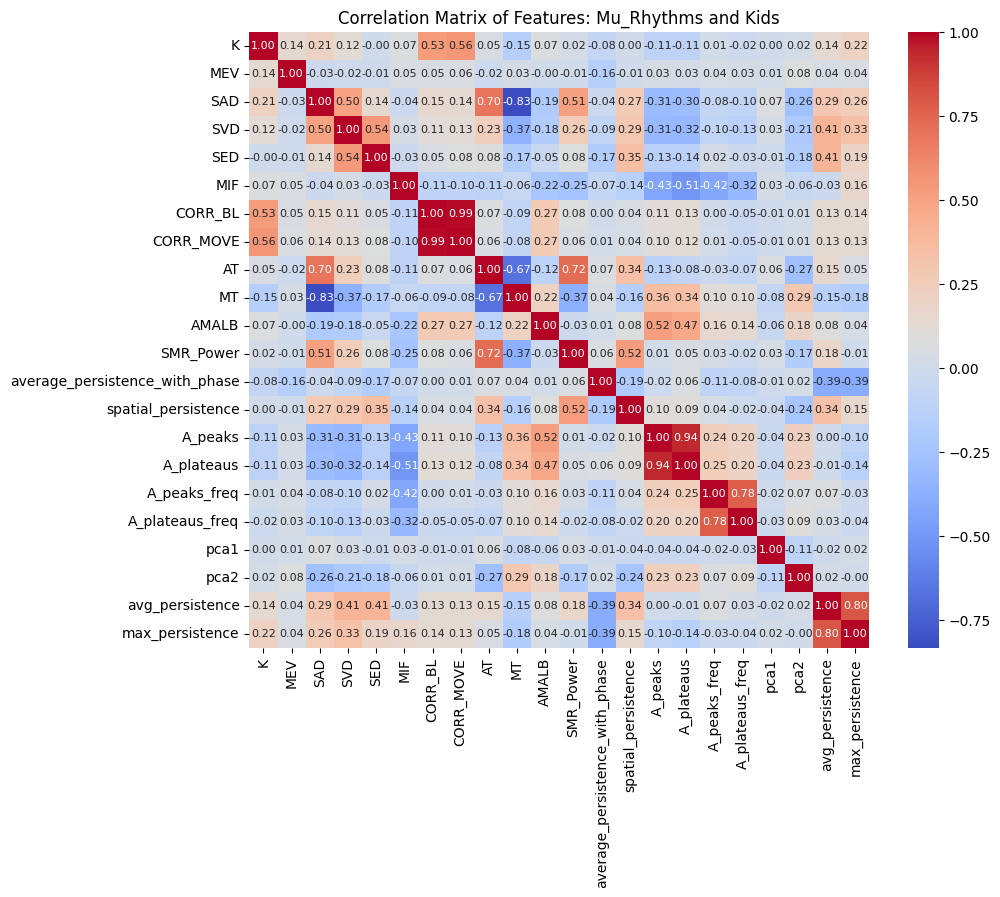

In [61]:
import seaborn as sns
import os
# Computing the correlation matrix
correlation_matrix = features_combined.corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
plt.title(f'Correlation Matrix of Features: Mu_Rhythms and Kids')
plt.show()
